All the code will be uploaded in my github: https://github.com/AntoniaBonfa/gbsv_MC2

In [1]:
# general imports
import cv2 as cv
import numpy as np
import pandas as pd
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Import images
items = cv.imread('images/souvenirs.jpg')
items = cv.cvtColor(items, cv.COLOR_BGR2RGB)



## Day 5: Define Segmentation Use Case & Select Image

For this task, I took a picture of some souvenirs I brought home from my travel. This image has been taken specifically for this task, so it is not a good representation of the real world. It contains some of the items I associate with my trip: the flower because they are everywhere and women often wear them in their hair as casual decoration. Various shells I collected at the beach, as well as two small pearls I bought for their unique shape and color. The last item  is technically not from French Polynesia, but from the Cook islands, which is also a tropical island: a triangle shaped coin, which is unique in the world and therefore a popular souvenir. I only included it because it might produce an intersting skeleton (and it's a fun souvenir to show off).

In general, a practical use case for some of these objects could be for example measuring and counting pearls to be able to sort them easily according to their value: as Polynesia produces a lot of pearls you can find bins full of lesser quality pearls at markets which are priced according to their purity, size and color. Being able to automatically measure them from an image could be therefore helpful for sorting. As my image only contains two pearls (which are both low quality and only cost around 10€) I don't expect that kind of insight from my image.

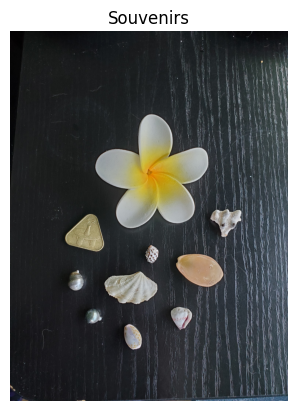

In [2]:
plt.imshow(items)
plt.axis('off')
plt.title('Souvenirs')
plt.show()

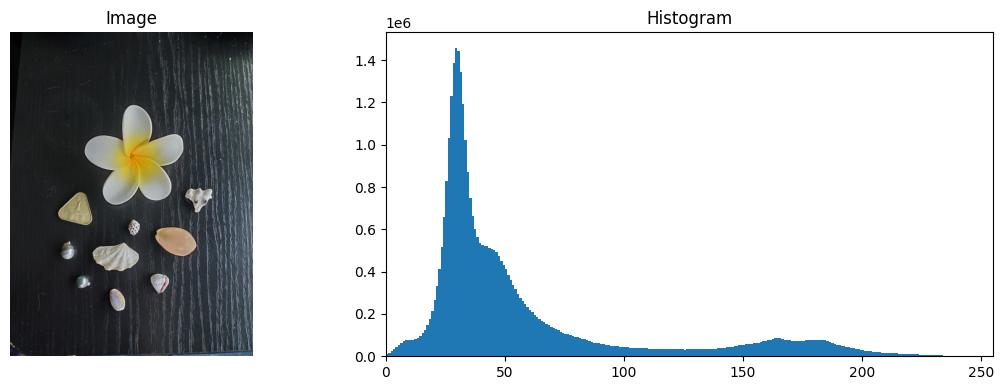

In [3]:
def plot_img_with_hist(img, cmap='gray', bins=255, xlim_min=0, xlim_max=255):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    axs[0].imshow(img, cmap=cmap)
    axs[0].axis('off')
    axs[0].set_title("Image")
    axs[1].hist(img.flatten(), bins=bins)
    axs[1].set_xlim(xlim_min,xlim_max)
    axs[1].set_title("Histogram")
    plt.tight_layout()
    plt.show()

plot_img_with_hist(items)

## Day 6: Image Segmentation
To segment my image, I will use the Otsu method, which segments the image based on thresholds, which are determined from the intensity of the pixels. Thankfully, my image has a black background and fairly light items, so I wont have to tweak the image or the method for a good result. 
I will be using skimages threshold_otsu method, which will return a binary output. 

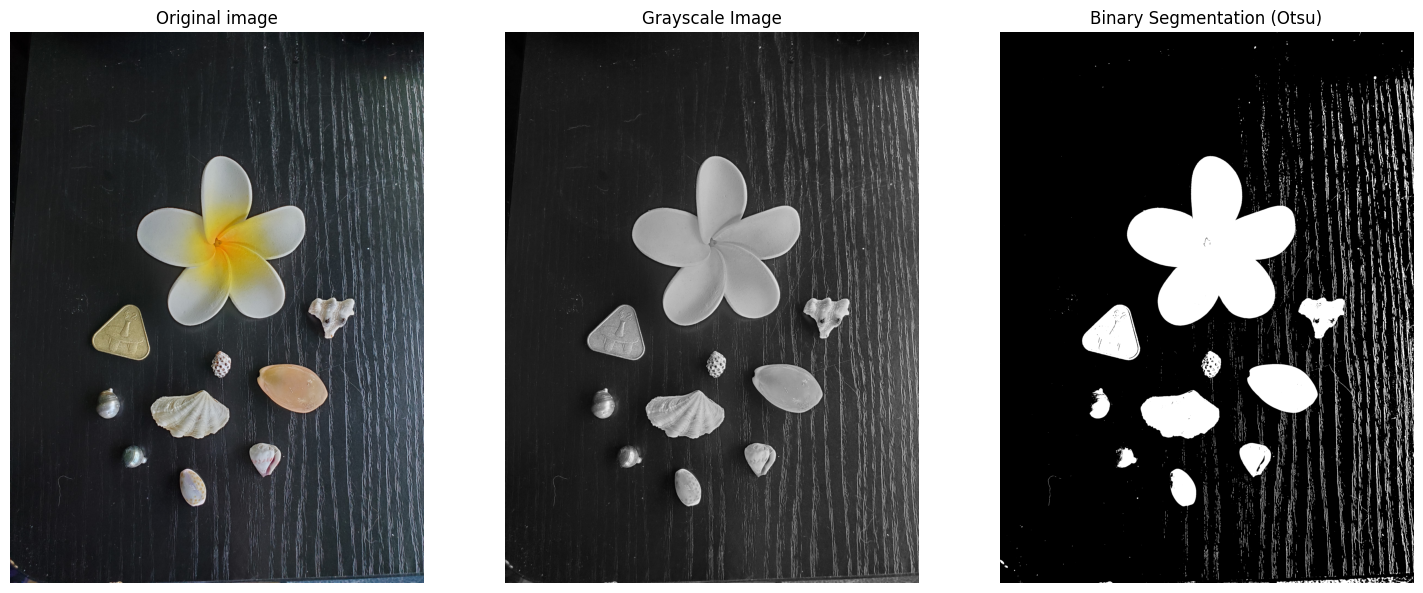

In [4]:
from skimage.filters import threshold_otsu

items_gray = cv.cvtColor(items, cv.COLOR_RGB2GRAY)

thresholds = threshold_otsu(items_gray, nbins=2)
binary = items_gray >= thresholds

fig, ax = plt.subplots(1,3,figsize=(15, 6))

ax[0].imshow(items, cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(items_gray, cmap='gray')
ax[1].set_title('Grayscale Image')
ax[1].axis('off')

ax[2].imshow(binary, cmap='gray')
ax[2].set_title('Binary Segmentation (Otsu)')
ax[2].axis('off')

plt.tight_layout()
plt.show()

## Day 7: Morphological Operations
As we can see in yesterdays image, the segmentation worked quite well. However, some of the shells have dark dots that need to be filled. Additionally, the engraving on the coin is visible - if I want to just have the shape, I need to also fill that. The pearls unfortunately have some shade, but I don't think that can be avoided. I will try to fill the holes in the shells and the engraving on the coin with morphological operations.
As the background has wood structure that could end up being made bigger, I will first use opening to remov as much of the white lines as possible. Afterwards, I will use closing - so dilate first, then erode again, to fill the holes in my items. To make the difference easier visible, I will plot the difference with green. As the lines are quite big, I will use 6 iterations and see how it looks. If this proves to be not enough, I will do more iterations or pick a bigger kernel.



In [5]:
def plot_difference(binary, closed):
    difference = (binary - closed).astype(bool)
    diff_rgb = np.stack([closed * 255] * 3, axis=-1).astype(np.uint8)
    diff_rgb[difference] = [0, 240, 0]
    return diff_rgb

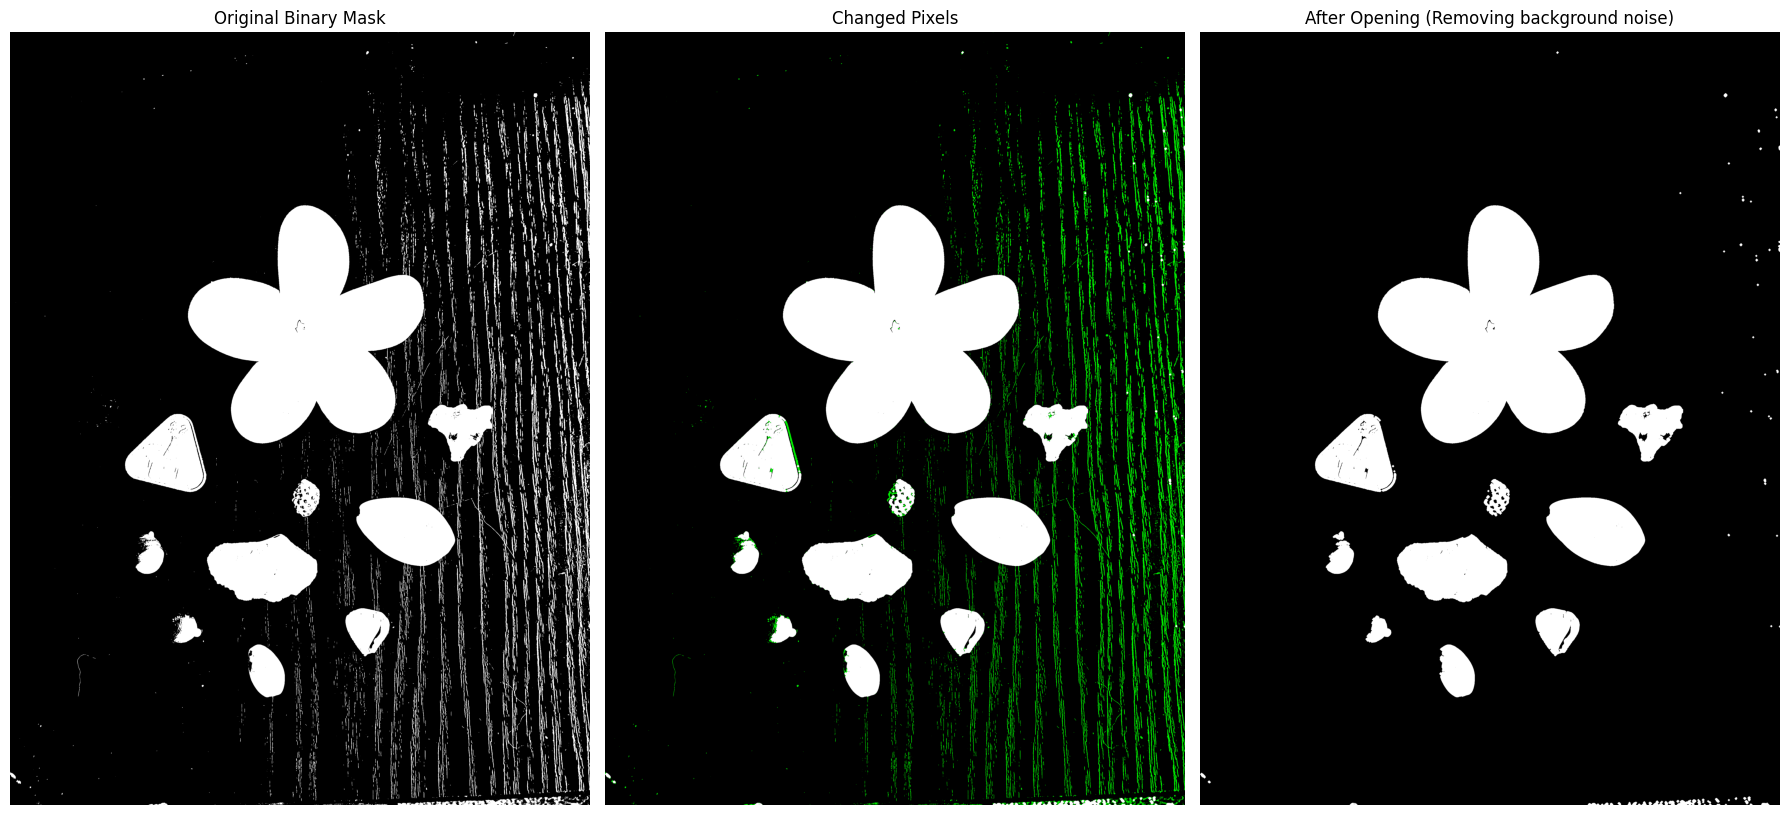

In [6]:
binary = binary.astype(np.uint8)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
opened = cv.morphologyEx(binary, cv.MORPH_OPEN, kernel, iterations=6)

fig, ax = plt.subplots(1, 3, figsize=(18, 12))

ax[0].imshow(binary, cmap='gray')
ax[0].set_title('Original Binary Mask')
ax[0].axis('off')

ax[1].imshow(plot_difference(binary, opened))
ax[1].set_title('Changed Pixels')
ax[1].axis('off')

ax[2].imshow(opened, cmap='gray')
ax[2].set_title('After Opening (Removing background noise)')
ax[2].axis('off')



plt.tight_layout()
plt.show()

The opening seems to have removed most of the background lines, now time to try closing. I will use a kernel of 3x3 pixels, as the items are not very big and I don't want to lose too much detail.

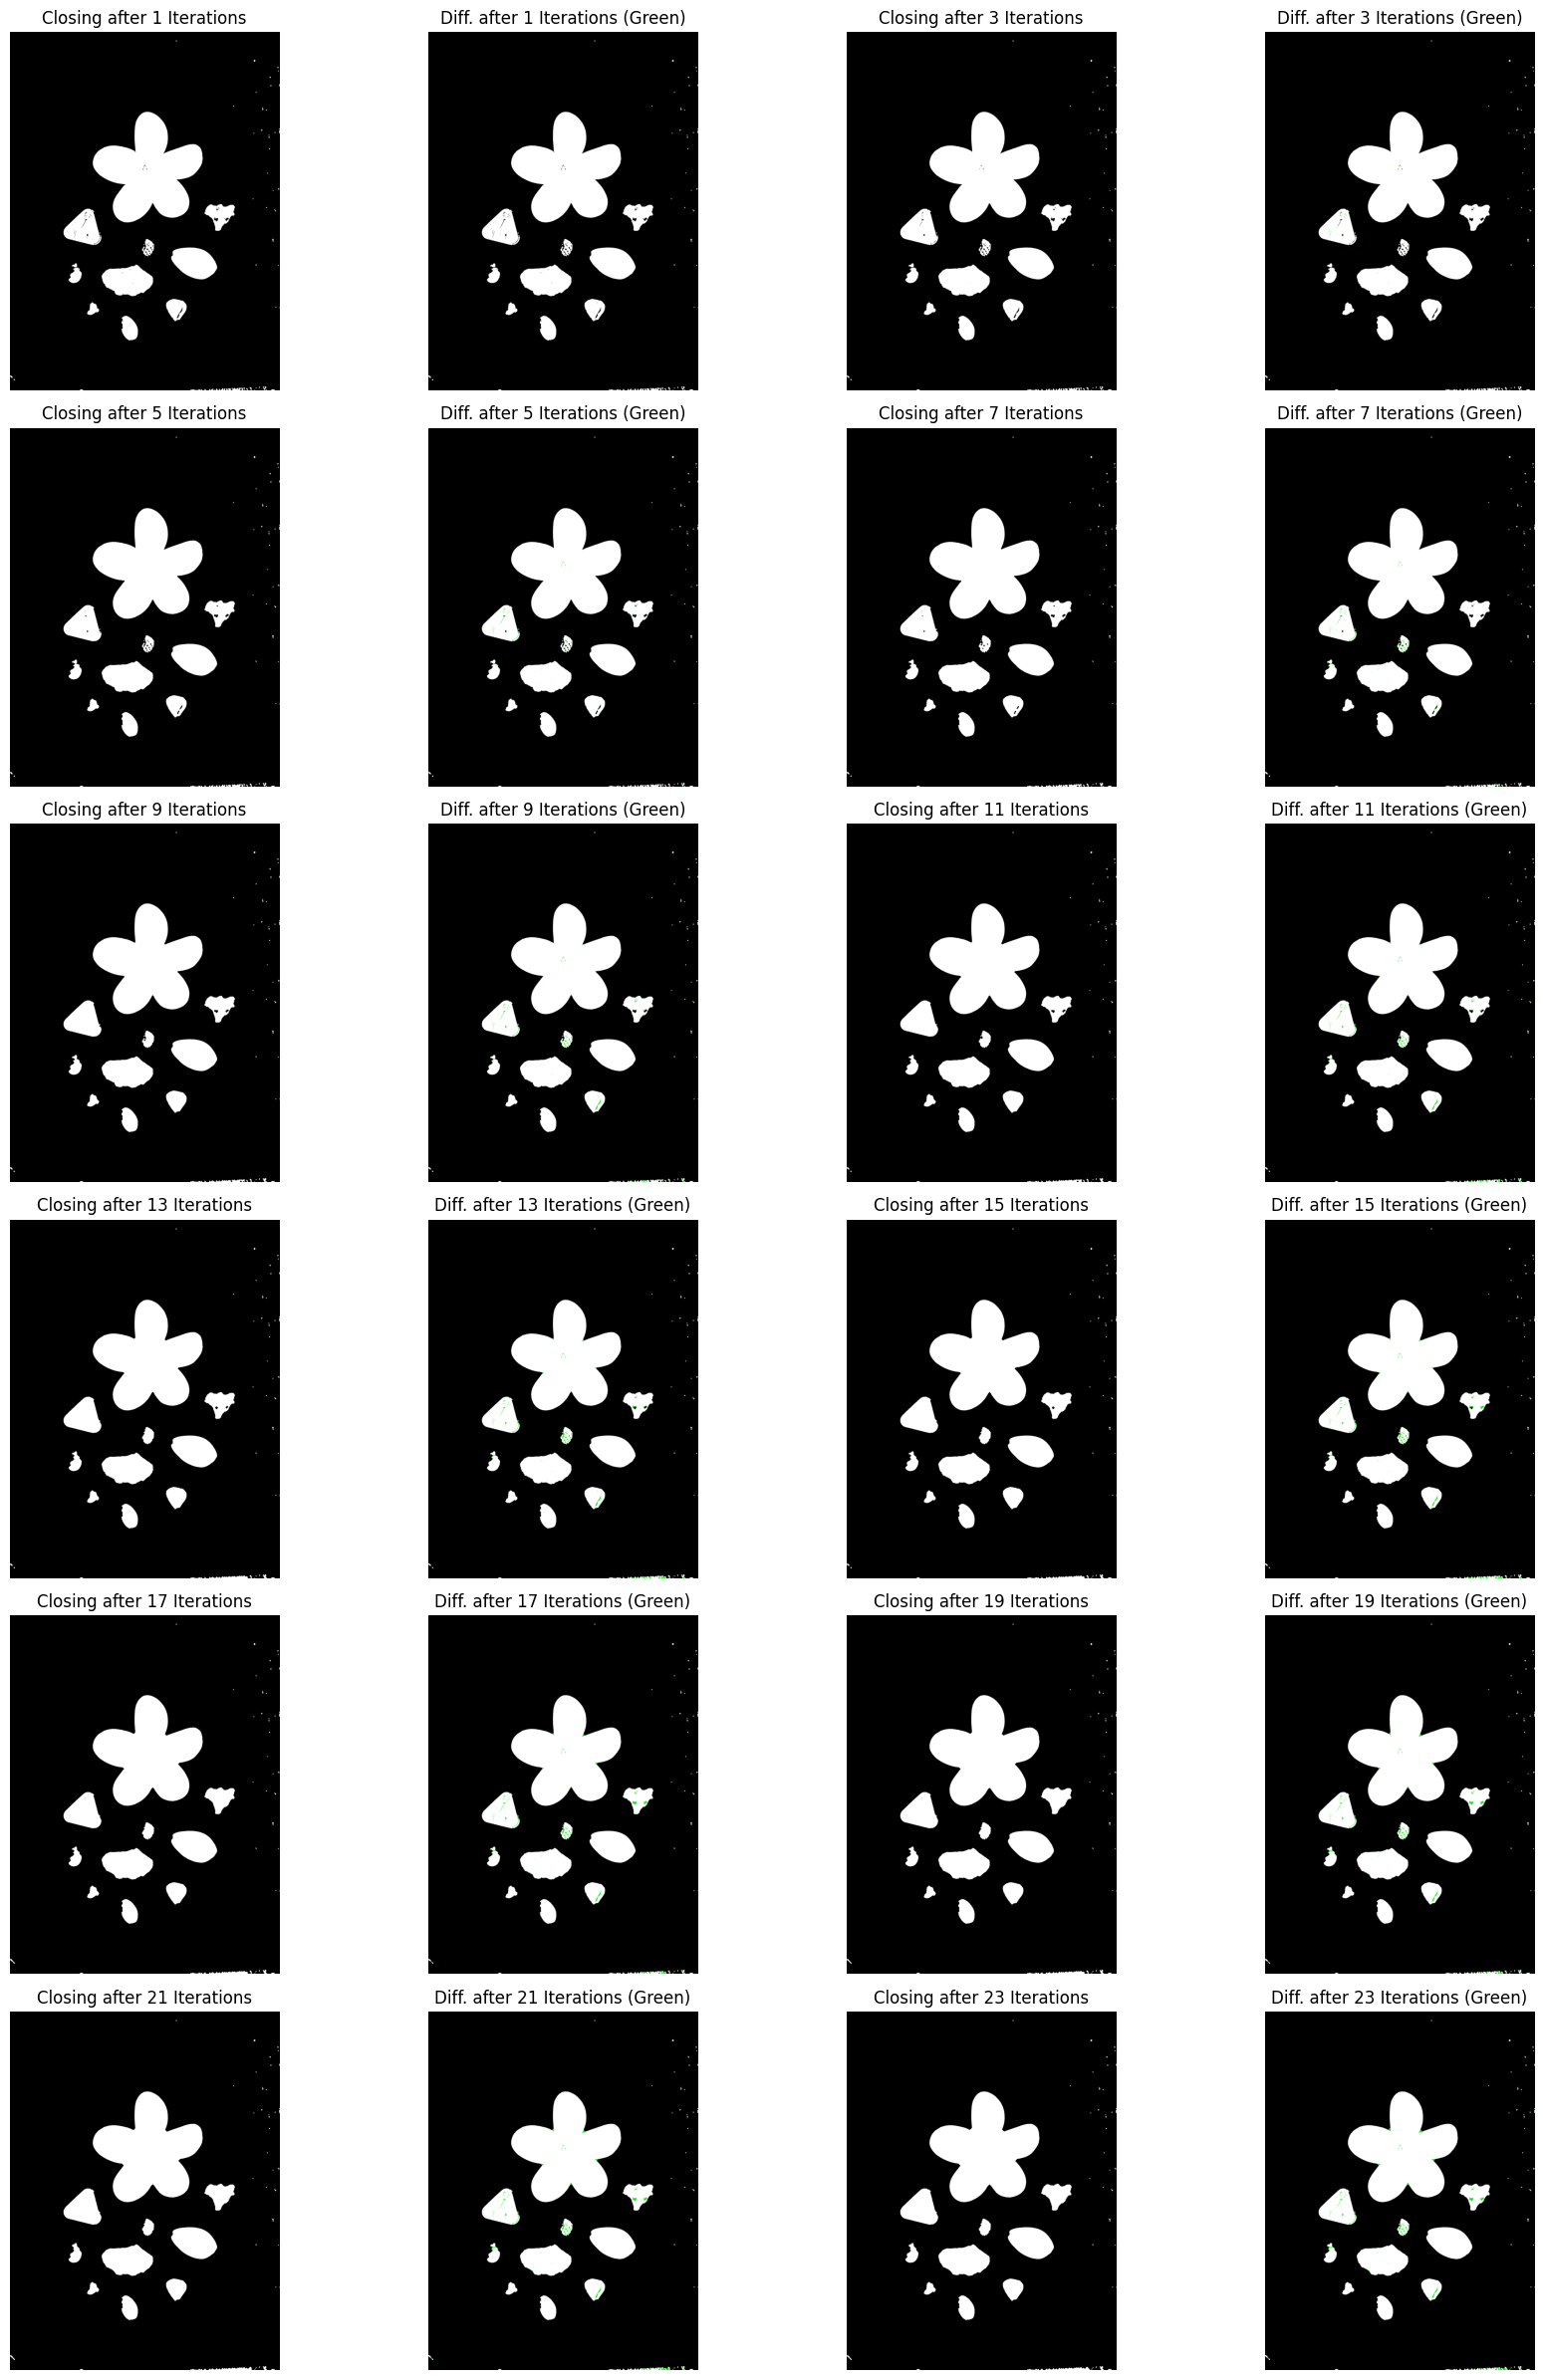

In [7]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))

n_iterations = 24
fig, ax = plt.subplots(6, 4, figsize=(18, 24))
axs = ax.flatten()

for i in range(0,n_iterations, 2):
    closed = cv.morphologyEx(opened, cv.MORPH_CLOSE, kernel, iterations=i)
    axs[i].imshow(closed, cmap='gray')
    axs[i].set_title(f'Closing after {i+1} Iterations')
    axs[i].axis('off')

    axs[i+1].imshow(plot_difference(opened, closed))
    axs[i+1].set_title(f'Diff. after {i+1} Iterations (Green)')
    axs[i+1].axis('off')

plt.tight_layout()
plt.show()





It seems like after 17 iterations, all the black pixels are filled. To properly show the effect of the morphological experiments, I will now plot the original, opened, closed and difference plot once more:

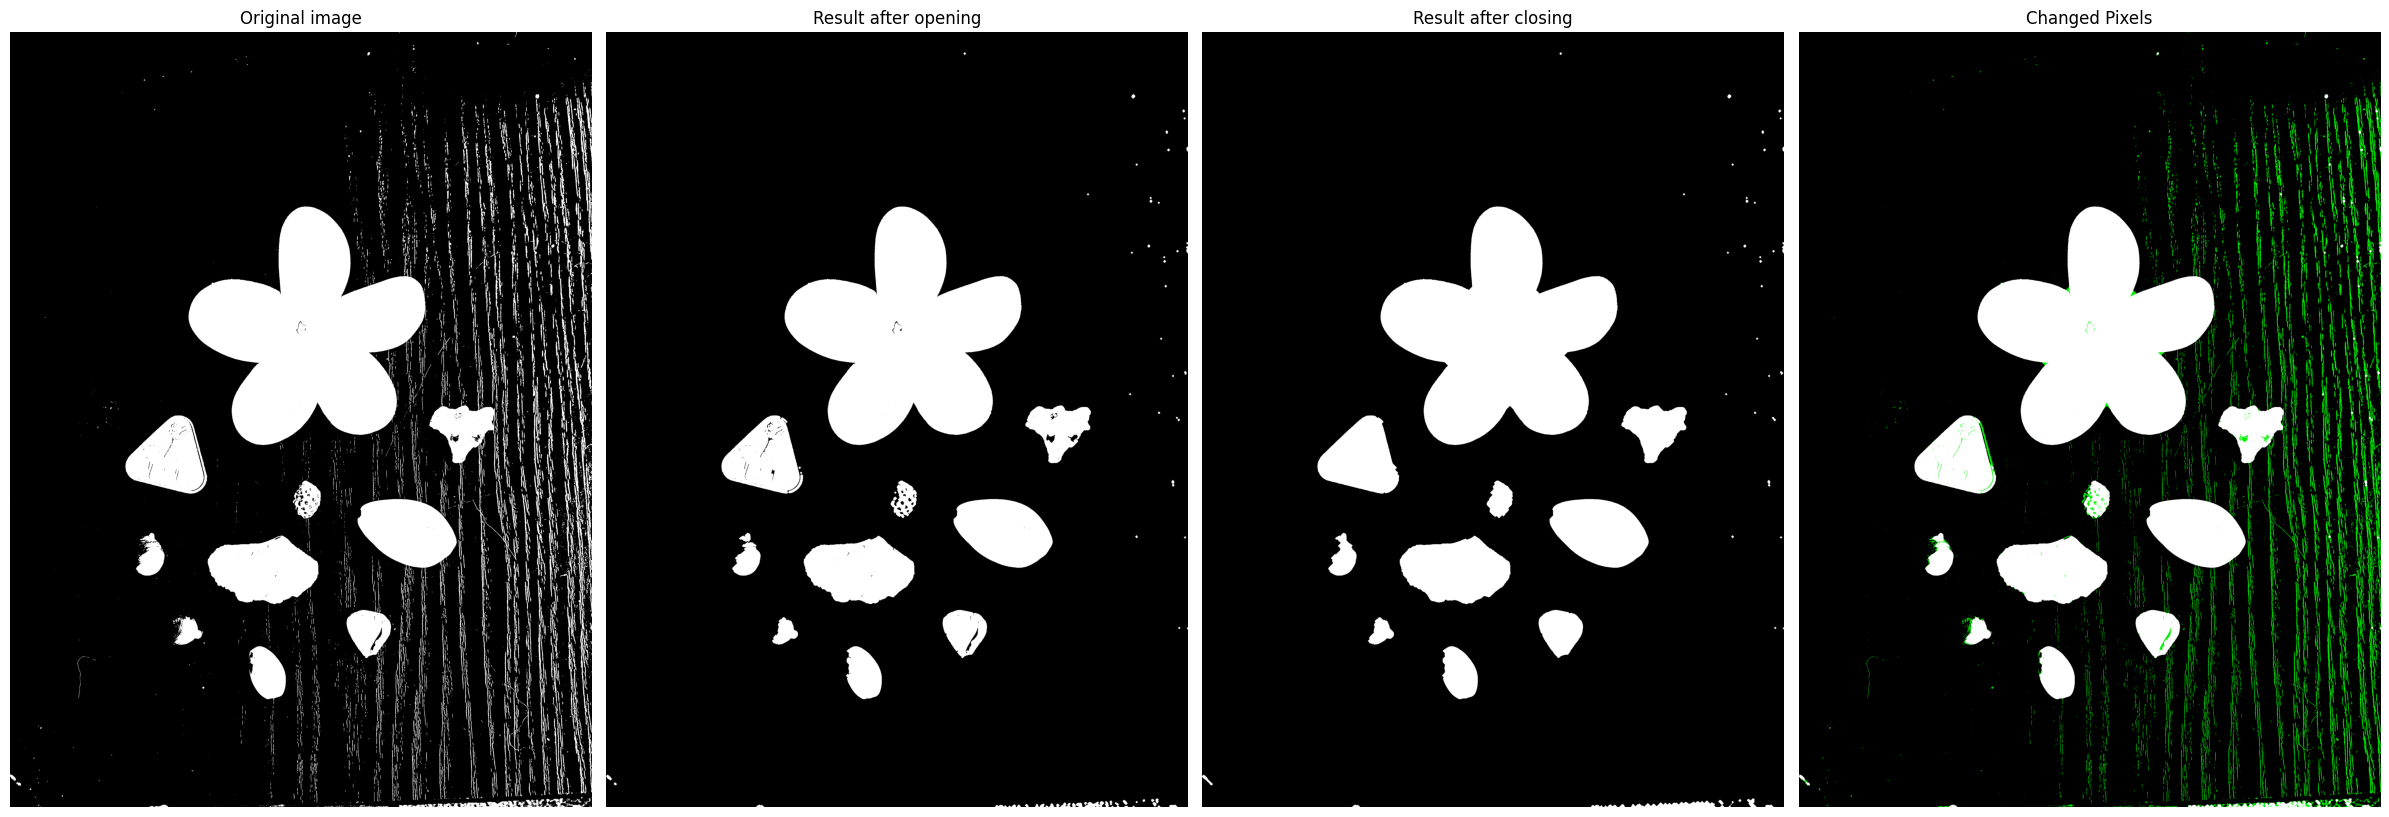

In [8]:
closed_final = cv.morphologyEx(opened, cv.MORPH_CLOSE, kernel, iterations=17)

fig, ax = plt.subplots(1, 4, figsize=(24, 16))

ax[0].imshow(binary, cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(opened, cmap='gray')
ax[1].set_title('Result after opening')
ax[1].axis('off')

ax[2].imshow(closed_final, cmap ='gray')
ax[2].set_title('Result after closing')
ax[2].axis('off')

ax[3].imshow(plot_difference(binary, closed_final))
ax[3].set_title('Changed Pixels')
ax[3].axis('off')
plt.tight_layout()
plt.show()

## Day 8: Extract and Measure Objects
To analyze my objects, I will be using the skimage.measure module. As my final segmentation mask did not completly erradicate some random white dots of the background, I will have to define a cut-off minimal size for objects, so that random noise is not identified as an object.
As for the properties of my items, I am chosing area,perimeter, length and width so I could compare the size of the objects. That would allow me to compare the similar sized shells as well as the pearls.

In [15]:
def extract_objects(original_img, binary_mask, min_area=200, show_plot=True):

    label_mask = label(binary_mask)
    all_regions = regionprops(label_mask)

    filtered_mask = np.zeros_like(label_mask, dtype=np.uint8)
    filtered_regions = []

    for region in all_regions:
        if region.area >= min_area:
            filtered_mask[label_mask == region.label] = 1
            region.label = len(filtered_regions) + 1
            filtered_regions.append(region)

    df_props = pd.DataFrame({
        'Label': [r.label for r in filtered_regions],
        'Area': [r.area for r in filtered_regions],
        'Perimeter': [r.perimeter for r in filtered_regions],
        'Length (major axis)': [r.major_axis_length for r in filtered_regions],
        'Width (minor axis)': [r.minor_axis_length for r in filtered_regions],
    })

    if show_plot:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(original_img)
        for r in filtered_regions:
            y0, x0 = r.centroid
            orientation = r.orientation
            length = 0.5 * r.axis_major_length
            width = 0.5 * r.axis_minor_length
            x1 = x0 + np.cos(orientation) * width
            y1 = y0 - np.sin(orientation) * width
            x2 = x0 - np.sin(orientation) * length
            y2 = y0 - np.cos(orientation) * length

            ax.plot((x0, x1), (y0, y1), '-r' , linewidth=2.5)
            ax.plot((x0, x2), (y0, y2), '-b',linewidth=2.5)
            ax.plot(x0, y0, '.g', markersize=10)

            minr, minc, maxr, maxc = r.bbox
            bx = (minc, maxc, maxc, minc, minc)
            by = (minr, minr, maxr, maxr, minr)
            ax.plot(bx, by, '-r', linewidth=2)

            cy, cx = r.centroid
            ax.text(cx, cy, str(r.label), color='yellow', fontsize=12, ha='center')
        ax.set_title('Filtered Objects with Bounding Boxes')
        ax.axis('off')
        plt.show()

    return filtered_regions, df_props


to define a cut-off size for the objects, I will first run my function without a plot - as I can count my items by hand, I know that I want to have the 10 biggest regions. If this turns out to be wrong and there is still random noise that is bigger than my smallest actual item, I will have to pre-process the item better (or cut the image to be mainly the items, so less chance of interference from the background).

In [16]:
regions, df = extract_objects(items, closed_final, show_plot=False)
print(df.sort_values(by = 'Area', ascending=False).head(11))

    Label      Area    Perimeter  Length (major axis)  Width (minor axis)
1       2  864604.0  5123.290040          1141.079245         1106.929723
10     11  144017.0  1596.753534           571.144682          325.541367
8       9  133439.0  1443.716954           520.759138          327.676300
4       5  111322.0  1397.900720           399.820475          389.506765
3       4   59892.0  1158.964646           315.884249          280.033498
11     12   40070.0   792.347330           240.700258          218.144329
13     14   37856.0   814.974747           285.259753          171.268274
9      10   19009.0   691.217388           220.900734          124.856856
7       8   17559.0   580.063059           186.771207          122.427486
12     13   11224.0   484.724963           144.857739          110.521134
17     18    8033.0  1058.856998           472.168641           26.666938


Based on the list, the 10 largest regions have an area bigger than 10000. I will therefore use that for my cut-off:

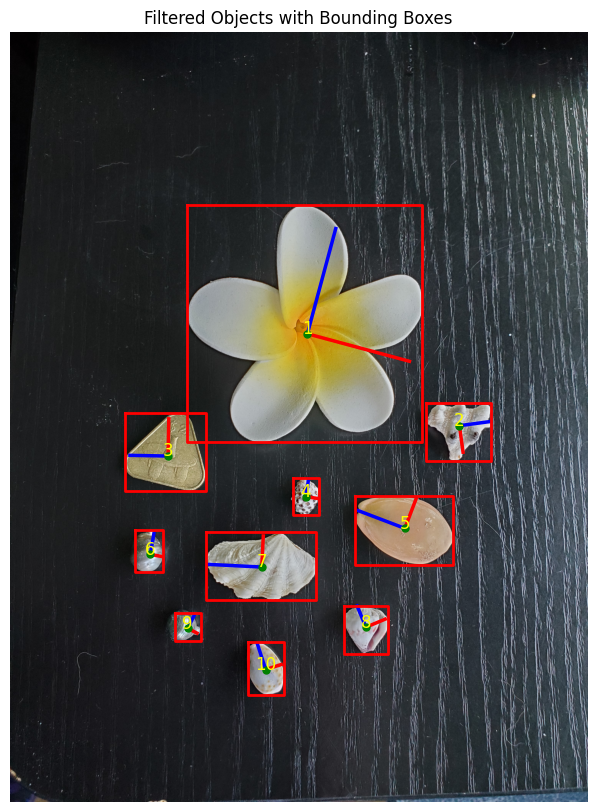

Number of items: 10
   Label      Area    Perimeter  Length (major axis)  Width (minor axis)
0      1  864604.0  5123.290040          1141.079245         1106.929723
1      2   59892.0  1158.964646           315.884249          280.033498
2      3  111322.0  1397.900720           399.820475          389.506765
3      4   17559.0   580.063059           186.771207          122.427486
4      5  133439.0  1443.716954           520.759138          327.676300
5      6   19009.0   691.217388           220.900734          124.856856
6      7  144017.0  1596.753534           571.144682          325.541367
7      8   40070.0   792.347330           240.700258          218.144329
8      9   11224.0   484.724963           144.857739          110.521134
9     10   37856.0   814.974747           285.259753          171.268274


In [18]:
regions, item_properties = extract_objects(items, closed_final, show_plot=True, min_area=10000)
print(f'Number of items: {len(item_properties)}')
print(item_properties.sort_values(by = 'Label'))

Lastly, I will calculate the statistics for my chosen properties:

In [20]:
print(item_properties.describe())

          Label           Area    Perimeter  Length (major axis)  \
count  10.00000      10.000000    10.000000            10.000000   
mean    5.50000  143899.200000  1408.395338           402.717748   
std     3.02765  257947.260316  1361.567869           294.628904   
min     1.00000   11224.000000   484.724963           144.857739   
25%     3.25000   23720.750000   716.499873           225.850615   
50%     5.50000   49981.000000   986.969696           300.572001   
75%     7.75000  127909.750000  1432.262896           490.524472   
max    10.00000  864604.000000  5123.290040          1141.079245   

       Width (minor axis)  
count           10.000000  
mean           317.690573  
std            294.244049  
min            110.521134  
25%            136.459711  
50%            249.088914  
75%            327.142566  
max           1106.929723  


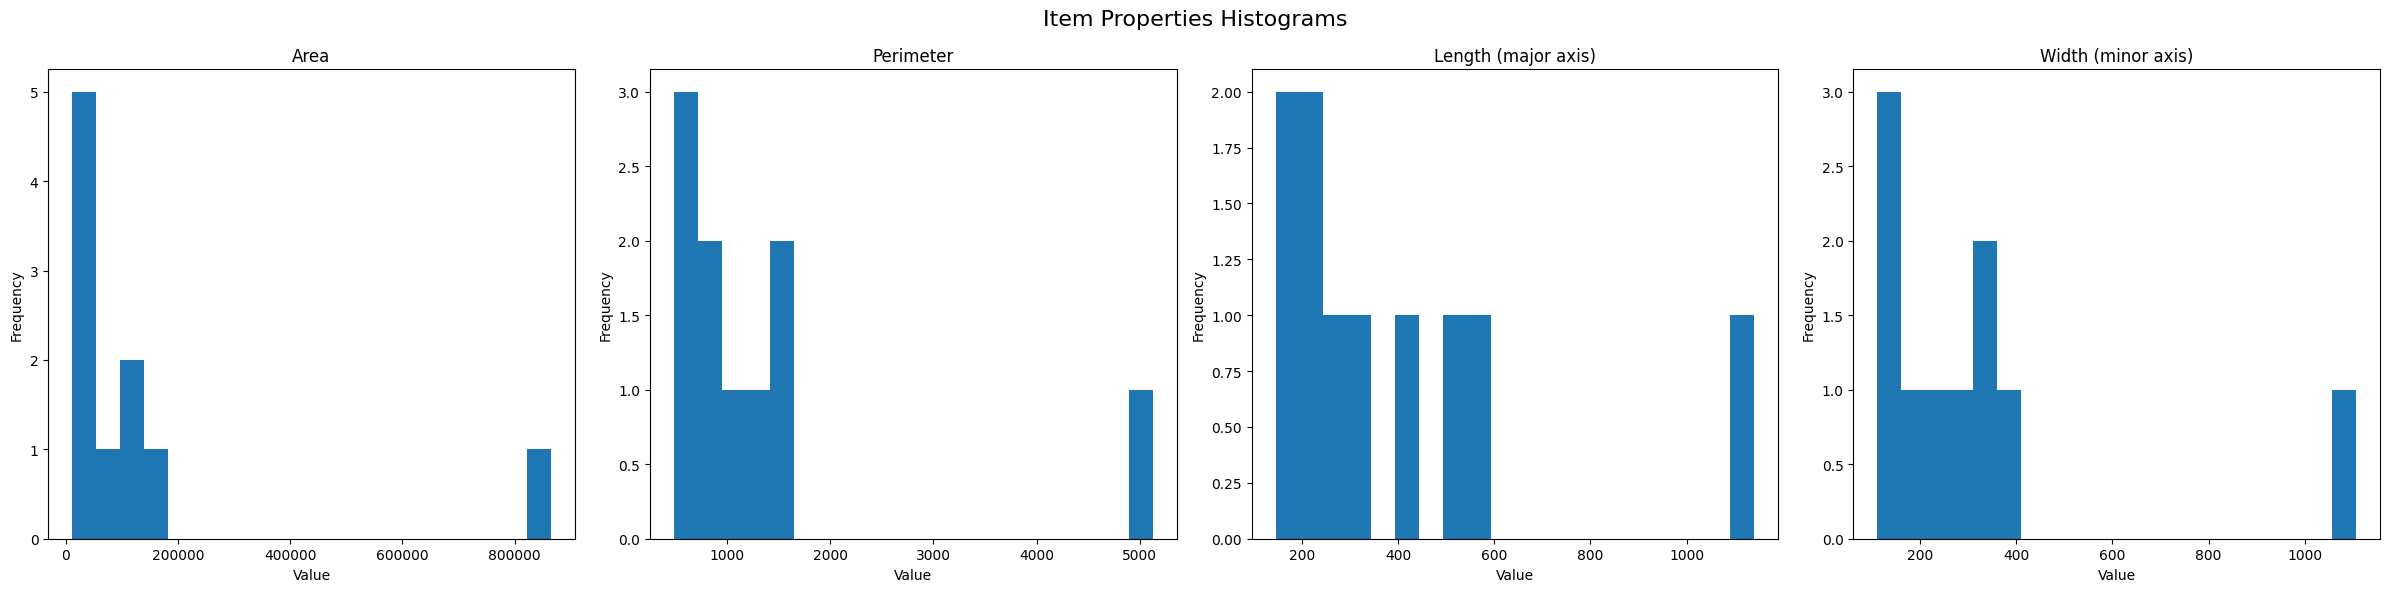

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(24, 6))
plt.suptitle('Item Properties Histograms', fontsize=16)
for i, column in enumerate(item_properties.columns[1:]):
    ax[i].hist(item_properties[column], bins=20)
    ax[i].set_title(column)
    ax[i].set_xlabel('Value')
    ax[i].set_ylabel('Frequency')
plt.tight_layout()

As we can see from the histogram, the flower throws off the statistics a bit, as it is much bigger than the other items. We can also see that most items are very comparable in size.

## Day 9: Skeletonization
As I don't expect any interesting skeleton from most of my shells (it would probably only be a line), I will visualize the skeleton of the flower and the coin. I will use the skimage.morphology.skeletonize function for this and just use the default parameters for starting. I will also plot the original image and the skeletonized image next to each other for comparison, with the pixel count in the title.

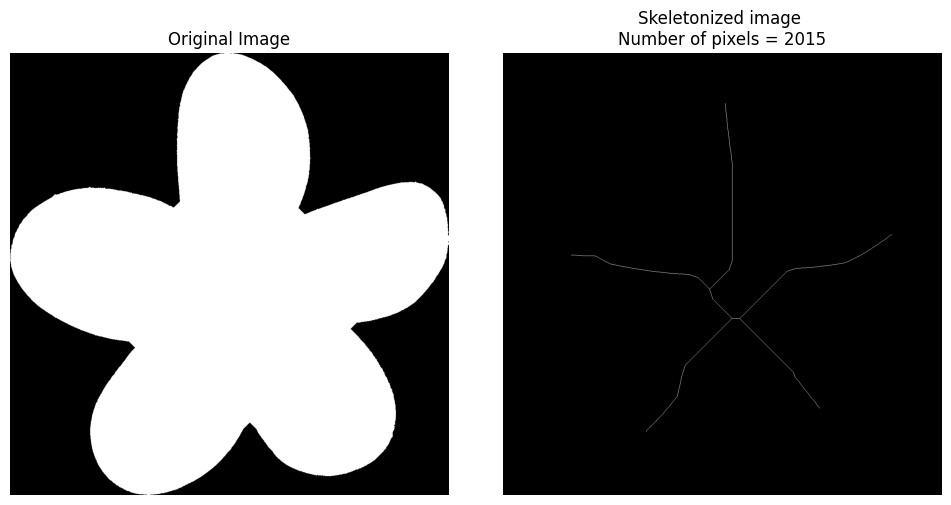

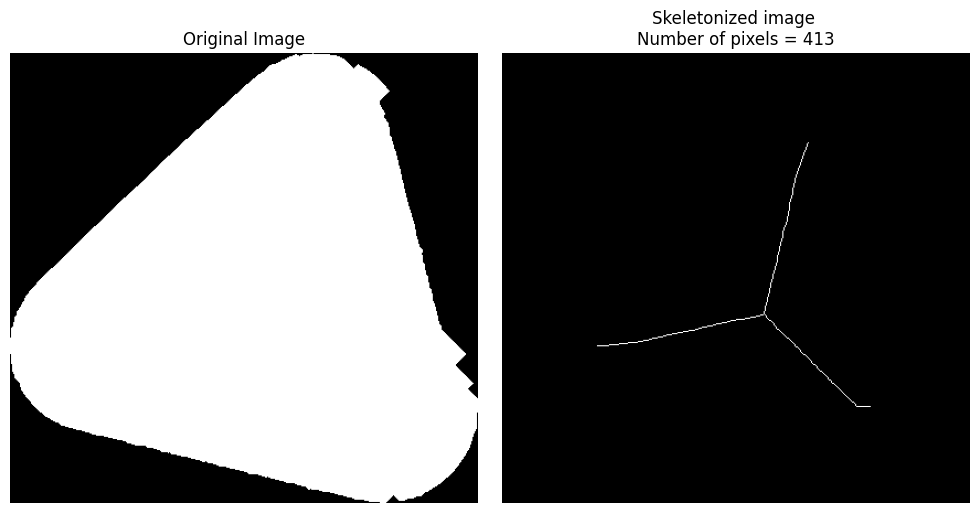

In [40]:
from skimage.morphology import skeletonize
flower = regions[0]
coin = regions[2]

for region in [flower, coin]:
    skeleton = skeletonize(region.image)
    skeleton_pixels = np.count_nonzero(skeleton)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(region.image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    ax[1].imshow(skeleton, cmap='gray')
    ax[1].set_title(f'Skeletonized image \nNumber of pixels = {skeleton_pixels}')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()